In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
mnist = np.load('mnist.npz')

In [3]:
train_X = mnist['x_train']
train_y = mnist['y_train']

test_X = mnist['x_test']
test_y = mnist['y_test']

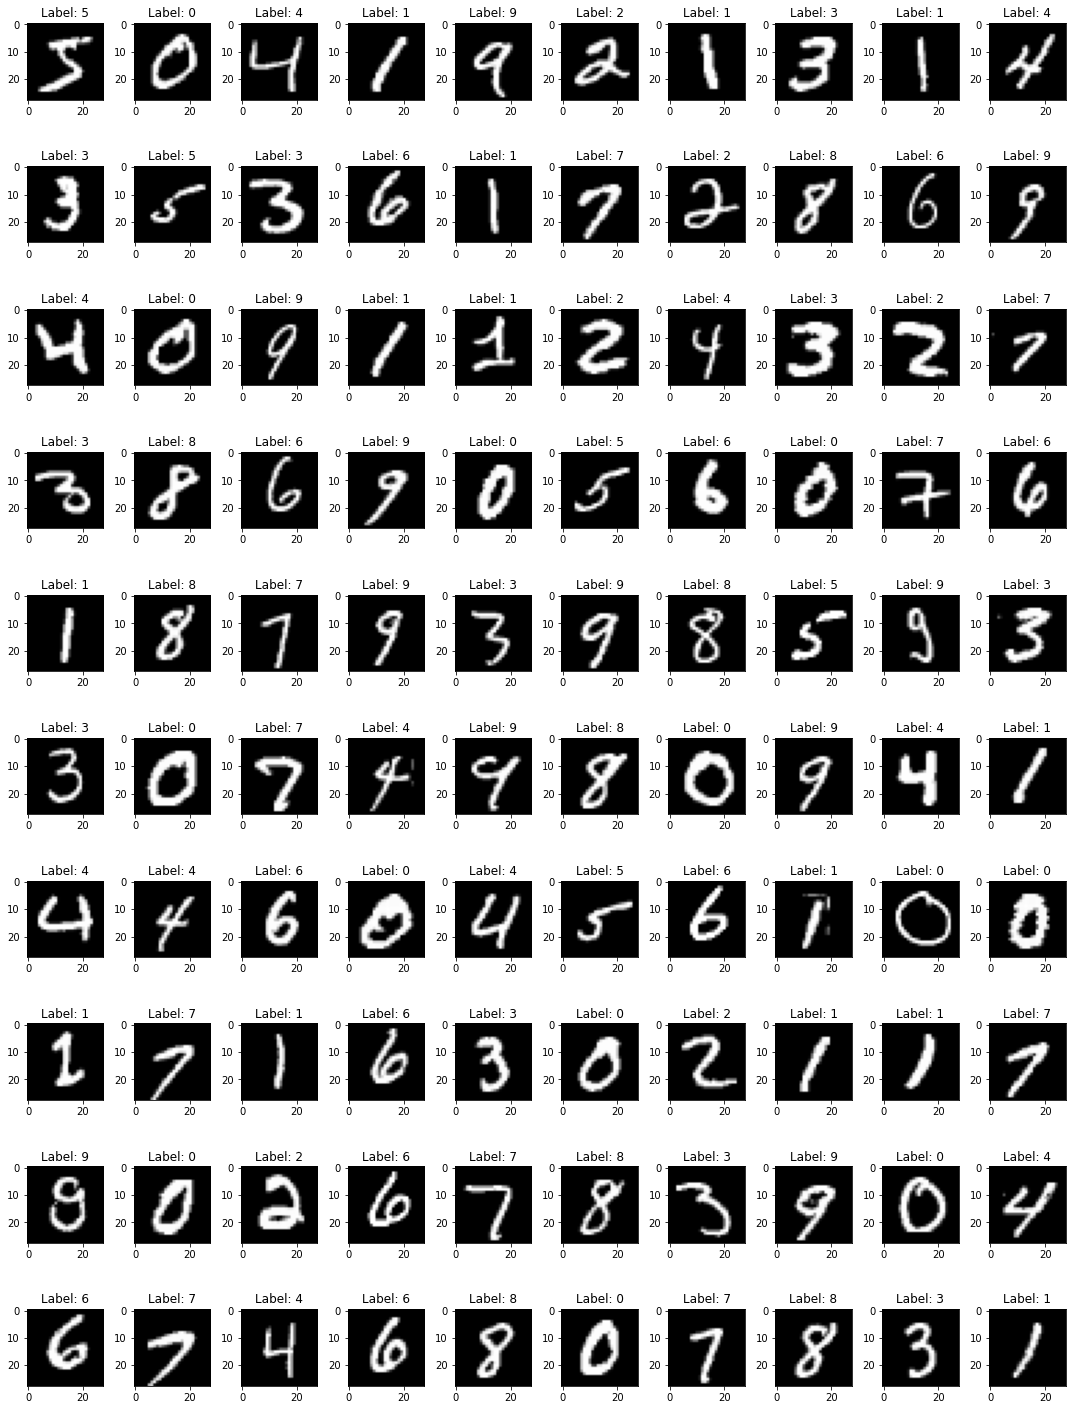

In [4]:
num_row = 10
num_col = 10

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(100):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(train_X[i], cmap='gray')
    ax.set_title('Label: {}'.format(train_y[i]))
plt.tight_layout()
plt.show()

In [5]:
class Present:

    def __init__(self, key, rounds=32):
        """Create a PRESENT cipher object

        key:    the key as a 128-bit or 80-bit rawstring
        rounds: the number of rounds as an integer, 32 by default
        """
        self.rounds = rounds
        if key.bit_length() == 80:
            self.roundkeys = generateRoundkeys80(key, self.rounds)
        elif key.bit_length() == 128:
            self.roundkeys = generateRoundkeys128(key, self.rounds)
        else:
            raise ValueError("Key must be a 128-bit or 80-bit rawstring")

    def encrypt(self, state):
        """Encrypt 1 block (8 bytes)

        Input:  plaintext block as raw string
        Output: ciphertext block as raw string
        """
        for i in range(self.rounds - 1):
            state = addRoundKey(state, self.roundkeys[i])
            state = sBoxLayer(state)
            state = pLayer(state)
        cipher = addRoundKey(state, self.roundkeys[-1])
        return cipher

    def decrypt(self, state):
        """Decrypt 1 block (8 bytes)

        Input:  ciphertext block as raw string
        Output: plaintext block as raw string
        """
        for i in range(self.rounds - 1):
            state = addRoundKey(state, self.roundkeys[-i - 1])
            state = pLayer_dec(state)
            state = sBoxLayer_dec(state)
        decipher = addRoundKey(state, self.roundkeys[0])
        return decipher

    def get_block_size(self):
        return 8


#        0   1   2   3   4   5   6   7   8   9   a   b   c   d   e   f
Sbox = [0xc, 0x5, 0x6, 0xb, 0x9, 0x0, 0xa, 0xd, 0x3, 0xe, 0xf, 0x8, 0x4, 0x7, 0x1, 0x2]
Sbox_inv = [Sbox.index(x) for x in range(16)]
PBox = [0, 16, 32, 48, 1, 17, 33, 49, 2, 18, 34, 50, 3, 19, 35, 51,
        4, 20, 36, 52, 5, 21, 37, 53, 6, 22, 38, 54, 7, 23, 39, 55,
        8, 24, 40, 56, 9, 25, 41, 57, 10, 26, 42, 58, 11, 27, 43, 59,
        12, 28, 44, 60, 13, 29, 45, 61, 14, 30, 46, 62, 15, 31, 47, 63]
PBox_inv = [PBox.index(x) for x in range(64)]


def generateRoundkeys80(key, rounds):
    """Generate the roundkeys for a 80-bit key

    Input:
            key:    the key as a 80-bit integer
            rounds: the number of rounds as an integer
    Output: list of 64-bit roundkeys as integers"""
    roundkeys = []
    for i in range(1, rounds + 1):  # (K1 ... K32)
        # rawkey: used in comments to show what happens at bitlevel
        # rawKey[0:64]
        roundkeys.append(key >> 16)
        # 1. Shift
        # rawKey[19:len(rawKey)]+rawKey[0:19]
        key = ((key & (2 ** 19 - 1)) << 61) + (key >> 19)
        # 2. SBox
        # rawKey[76:80] = S(rawKey[76:80])
        key = (Sbox[key >> 76] << 76) + (key & (2 ** 76 - 1))
        # 3. Salt
        # rawKey[15:20] ^ i
        key ^= i << 15
    return roundkeys


def generateRoundkeys128(key, rounds):
    """Generate the roundkeys for a 128-bit key

    Input:
            key:    the key as a 128-bit integer
            rounds: the number of rounds as an integer
    Output: list of 64-bit roundkeys as integers"""
    roundkeys = []
    for i in range(1, rounds + 1):  # (K1 ... K32)
        # rawkey: used in comments to show what happens at bitlevel
        roundkeys.append(key >> 64)
        # 1. Shift
        key = ((key & (2 ** 67 - 1)) << 61) + (key >> 67)
        # 2. SBox
        key = (Sbox[key >> 124] << 124) + (Sbox[(key >> 120) & 0xF] << 120) + (key & (2 ** 120 - 1))
        # 3. Salt
        # rawKey[62:67] ^ i
        key ^= i << 62
    return roundkeys


def addRoundKey(state, roundkey):
    return state ^ roundkey


def sBoxLayer(state):
    """SBox function for encryption

    Input:  64-bit integer
    Output: 64-bit integer"""

    output = 0
    for i in range(16):
        output += Sbox[(state >> (i * 4)) & 0xF] << (i * 4)
    return output


def sBoxLayer_dec(state):
    """Inverse SBox function for decryption

    Input:  64-bit integer
    Output: 64-bit integer"""
    output = 0
    for i in range(16):
        output += Sbox_inv[(state >> (i * 4)) & 0xF] << (i * 4)
    return output


def pLayer(state):
    """Permutation layer for encryption

    Input:  64-bit integer
    Output: 64-bit integer"""
    output = 0
    for i in range(64):
        output += ((state >> i) & 0x01) << PBox[i]
    return output


def pLayer_dec(state):
    """Permutation layer for decryption

    Input:  64-bit integer
    Output: 64-bit integer"""
    output = 0
    for i in range(64):
        output += ((state >> i) & 0x01) << PBox_inv[i]
    return output

In [6]:
images_present = train_X
labels_present = train_y

In [7]:
#accepts train_X[i]
def flatten(unflat_data):
  dim1_arr = []

  for i in range(len(unflat_data)):
    for j in range(len(unflat_data[i])):
      dim1_arr.append(unflat_data[i][j])

  return dim1_arr

In [8]:
#Converts 1D array back to 2D array
def unflatten(dim1_arr, x, y):
  final_X_data = [[0 for _ in range(y)] for _ in range(x)]
  dim1_arr.reverse()

  for i in range(x):
    for j in range(y):
      final_X_data[i][j] = dim1_arr.pop()

  return final_X_data

In [9]:
#convert to 2D 4 x N
def convert_8x98(dim1_arr):
  x = int(len(dim1_arr) / 8)
  y = 8

  speck_enc4D = [[0 for _ in range(y)] for _ in range(x)]

  ind = 0

  for i in range(x):
    for j in range(y):
      speck_enc4D[i][j] = dim1_arr[ind]
      ind = ind + 1

  return speck_enc4D

In [10]:
def convert_1x784_98(speck_enc4D):
  #convert to 2D 4 x N back to 1D array
  speck_enc4D_1D = []

  x = int(len(speck_enc4D))
  y = 8

  ind = 0

  for i in range(x):
    for j in range(y):
        speck_enc4D_1D.append(speck_enc4D[i][j])

  return speck_enc4D_1D

In [11]:
present = Present(0xb672b90f4a3ebbcc7c496d6de21ecea5)

In [12]:
def encrypt_present(speck_enc8D):
  #ENCRYPT 4X ARRAY
  ind = 0
  for i in speck_enc8D:

    #convert to INT
    int_val = int.from_bytes(i, "little")
    enc = present.encrypt(int_val)
    to_bytes = enc.to_bytes(8, byteorder='little')
    speck_enc8D[ind] = to_bytes

    ind = ind + 1

  return speck_enc8D

In [13]:
#SPECK ENCRYPTION PROCESS:
index = 0
for i in images_present:

  flat_arr = flatten(i)
  convert_8x = convert_8x98(flat_arr)
  enc = encrypt_present(convert_8x)
  flatten_8x = convert_1x784_98(enc)
  unflat_arr = unflatten(flatten_8x, len(i), len(i[0]))
  images_present[index] = unflat_arr
  index = index + 1

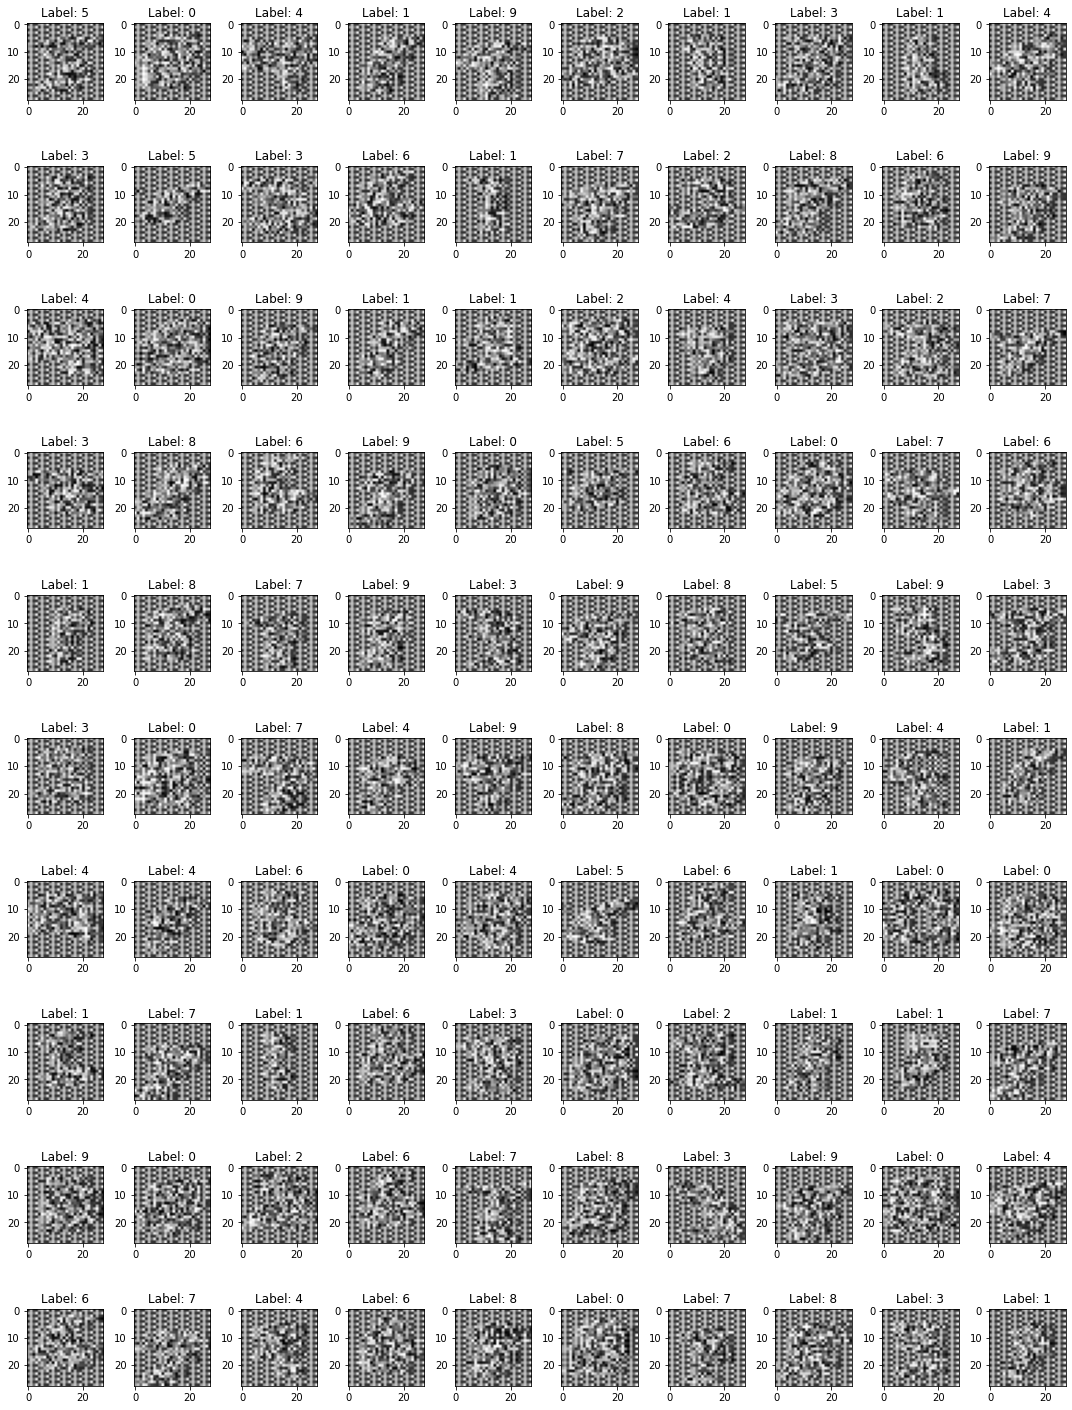

In [14]:
num_row = 10
num_col = 10
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(100):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images_present[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels_present[i]))
plt.tight_layout()
plt.show()

In [15]:
images_present

array([[[ 37, 182,  54, ..., 182,  54,  50],
        [155, 193, 109, ..., 193, 109, 231],
        [ 37, 182,  54, ..., 182,  54,  50],
        ...,
        [155, 193, 109, ..., 193, 109, 231],
        [ 37, 182,  54, ..., 182,  54,  50],
        [155, 193, 109, ..., 193, 109, 231]],

       [[ 37, 182,  54, ..., 182,  54,  50],
        [155, 193, 109, ..., 193, 109, 231],
        [ 37, 182,  54, ..., 182,  54,  50],
        ...,
        [155, 193, 109, ..., 193, 109, 231],
        [ 37, 182,  54, ..., 182,  54,  50],
        [155, 193, 109, ..., 193, 109, 231]],

       [[ 37, 182,  54, ..., 182,  54,  50],
        [155, 193, 109, ..., 193, 109, 231],
        [ 37, 182,  54, ..., 182,  54,  50],
        ...,
        [155, 193, 109, ..., 193, 109, 231],
        [ 37, 182,  54, ..., 182,  54,  50],
        [155, 193, 109, ..., 193, 109, 231]],

       ...,

       [[ 37, 182,  54, ..., 182,  54,  50],
        [155, 193, 109, ..., 193, 109, 231],
        [ 37, 182,  54, ..., 182,  54,  50

In [19]:
with open('present.pkl', 'wb') as f:
    pickle.dump(images_present, f)

In [ ]:
# noinspection PyUnresolvedReferences
from tensorflow.keras import layers